[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahdimplus/DeepRetroMoco/blob/main/network/train_with_validtiondatafunctions.ipynb)

In [4]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

In [30]:
d1='/content/drive/MyDrive/data/data selection_D1/S02_MSL.nii.gz'
import nibabel as nib

def load_m (file_path):
    
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    if img.shape[0:2]!=(64,64):
    
        img_data = img_data[23:87,23:87,:,:]
        
    if not (file_path.endswith(".nii") or file_path.endswith(".nii.gz")):
        raise ValueError(
              f"Nifti file path must end with .nii or .nii.gz, got {file_path}."
                        )
    return img_data
z=load_m(d1)



In [31]:
z1=z[...,4,0]
z2=z[...,4,80]

In [33]:
import numpy as np

In [34]:
import keras.backend as K


In [51]:
def TSNR(z1,z2):
    mean=(z1+z2)/2
    std1=(z1-mean)**2
    std2=(z2-mean)**2
    return K.mean(K.sqrt(sum(std1,std2)/2))


In [67]:
pip install voxelmorph


     |████████████████████████████████| 75 kB 2.3 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 


In [68]:
# imports
# local imports
import voxelmorph as vxm
import neurite as ne
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
import nibabel as nib

#import nbimporter
#from functions import *


In [69]:
#m=maxx(data_dir)
m=1584 

In [70]:
import random
def load_m (file_path):
    
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    if img.shape[0:2]!=(64,64):
    
        img_data = img_data[23:87,23:87,:,:]
        
    if not (file_path.endswith(".nii") or file_path.endswith(".nii.gz")):
        raise ValueError(
              f"Nifti file path must end with .nii or .nii.gz, got {file_path}."
                        )
    return img_data 
def count (data_dir):
    train_dir = os.path.join(data_dir)

    train_data_num = []
    for file in os.listdir(train_dir):
            train_data_num.append([file])
    train_data_num=np.array(train_data_num) 
    n=train_data_num.shape[0] 

    return n,train_data_num

In [71]:
def data_generator(data_dir, batch_size,m,split):
    """4
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    
    m= maximum between all subject 
    split= percent of validation data
    
    
    """
    
    n,train_data_num=count(data_dir)
    n_train=n-int(split*n)
 
    
    subject_ID=random.randint(0,n_train-1)
    d=load_m(data_dir+'/'+str(train_data_num[subject_ID][0]))

    
    s=d.shape[2]
    slice_ID =random.randint(0,s-1)
    v=d.shape[3]
    
 # preliminary sizing
    vol_shape = d.shape[:2] # extract data shape
    ndims = len(vol_shape)
    
    
    d=d[:,:,slice_ID,:]
    d = np.einsum('jki->ijk', d)

    
    
   
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, v, size=batch_size)
        moving_images = d[idx1, ..., np.newaxis]
        moving_images=moving_images/m
        
        idx2 = np.random.randint(0, v, size=batch_size)
        fixed_images = d[idx2, ..., np.newaxis]
        fixed_images=fixed_images/m
        
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)



def val_generator(data_dir, batch_size,m,split):
  
    n,train_data_num=count(data_dir)
    n_train=n-int(split*n)
    a=n_train
    
    
    subject_ID=random.randint(a,n-1)
    d=load_m(data_dir+'/'+str(train_data_num[subject_ID][0]))

    
    s=d.shape[2]
    slice_ID =random.randint(0,s-1)
    v=d.shape[3]
    
    # preliminary sizing
    vol_shape = d.shape[:2] # extract data shape
    ndims = len(vol_shape)
    
    
    d=d[:,:,slice_ID,:]
    d = np.einsum('jki->ijk', d)

 
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    # prepare inputs:
    # images need to be of the size [batch_size, H, W, 1]
    idx1 = np.random.randint(0, v, size=batch_size)
    moving_images = d[idx1, ..., np.newaxis]
    moving_images=moving_images/m

    idx2 = np.random.randint(0, v, size=batch_size)
    fixed_images = d[idx2, ..., np.newaxis]
    fixed_images=fixed_images/m

    inputs = [moving_images, fixed_images]

    # prepare outputs (the 'true' moved image):
    # of course, we don't have this, but we know we want to compare 
    # the resulting moved image with the fixed image. 
    # we also wish to penalize the deformation field. 
    outputs = [fixed_images,zero_phi]

    return (inputs, outputs)







In [72]:
data_dir='/content/drive/MyDrive/data/data selection_D1'

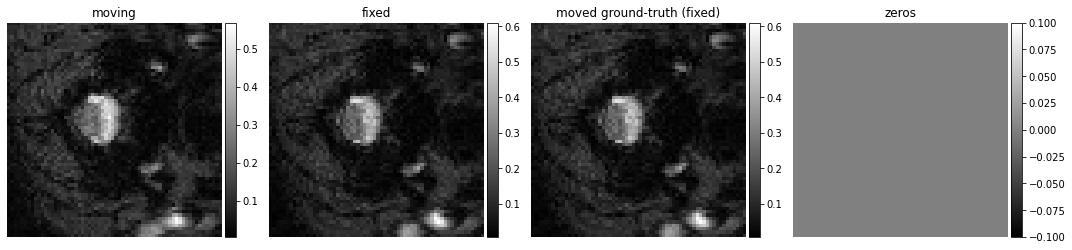

In [73]:
split=0.3  # it means 70% for train and 30% for validation


train_generator = data_generator(data_dir,100,m,split)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);


In [74]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
# data shape 64*64
s=in_sample[0].shape[1:3]
inshape = (*s, unet_input_features)

# configure unet features 
nb_features = [
    [64, 64, 64, 64],         # encoder features
    [64, 64, 64, 64, 64, 32,16]  # decoder features
]

#nb_features = [
#    [32, 32, 32, 32],         # encoder features
#    [32, 32, 32, 32, 32,16]  # decoder features
#           ]

In [75]:
s

(64, 64)

In [76]:
# build model using VxmDense
inshape =s
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
vxm_model.summary()

Model: "vxm_dense"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 target_input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 unet_input_concat (Concatenate  (None, 64, 64, 2)   0           ['source_input[0][0]',           
 )                                                                'target_input[0][0]']           
                                                                                                  
 unet_enc_conv_0_0 (Conv2D)     (None, 64, 64, 64)   1216        ['unet_input_concat[0][0]

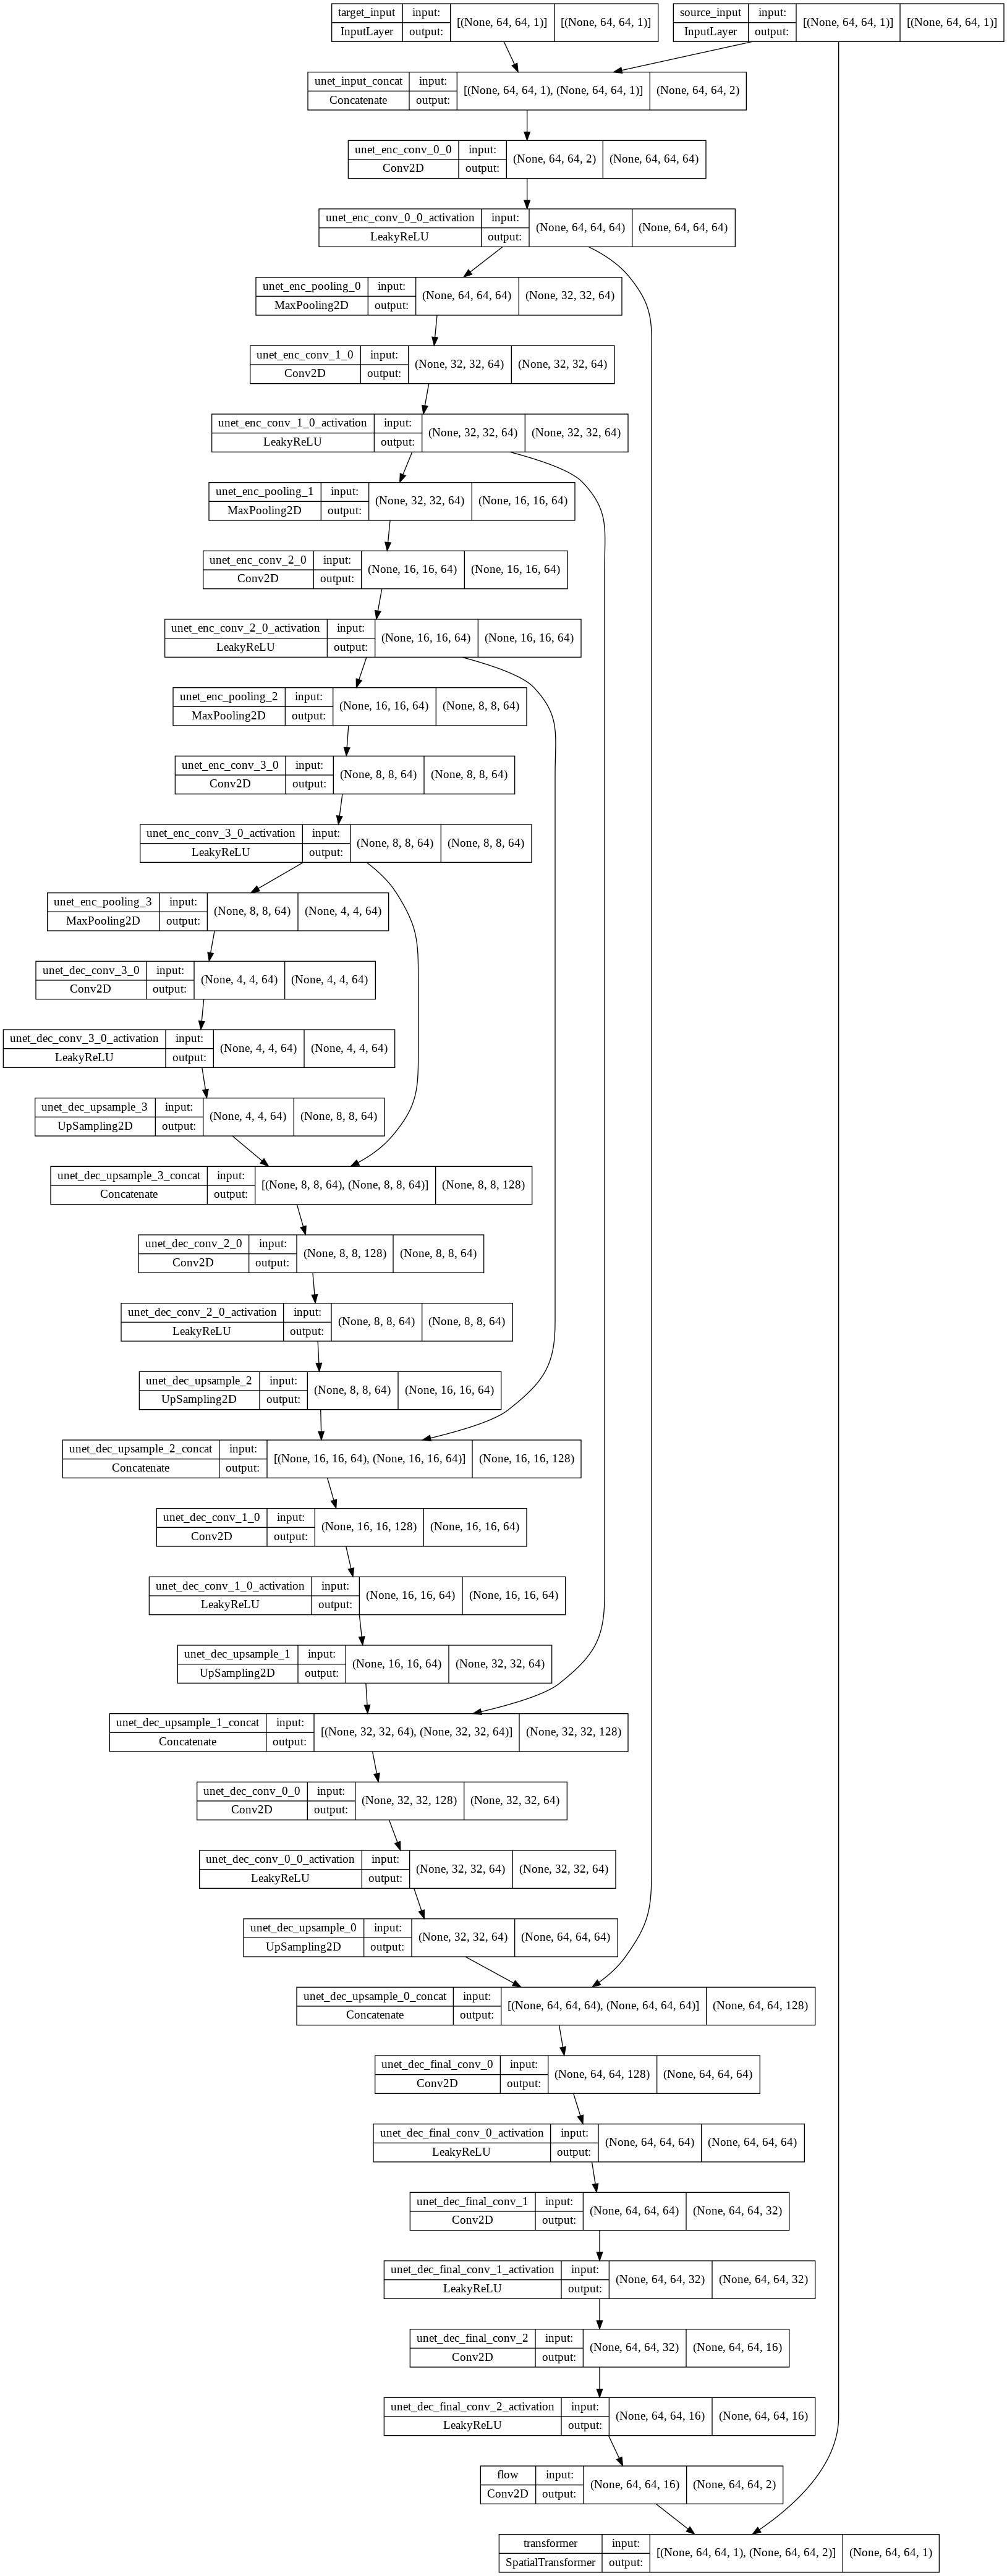

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(vxm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0
loss_weights = [1, lambda_param]

In [133]:
import numpy as np
import tensorflow as tf
from keras import backend as K
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [119]:
0/0

ZeroDivisionError: ignored

In [122]:
M=(z1+z2)/2
std1=(z1-M)**2
std2=(z2-M)**2
std=np.sqrt((std1+std2)/2)
#std[np.argwhere(std == 0)]=10e-5
f=(M/std)
f[np.argwhere(f == np.inf)]=0
np.average(f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


4.02476441721336

In [126]:
M/std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[  5.88888889,  19.85714286,   3.52631579, ...,   9.28571429,
         18.55555556,  29.        ],
       [ 26.6       ,   4.55555556,   8.2       , ...,   4.6       ,
          3.57894737, 171.        ],
       [  3.56      ,   3.8       ,   5.47058824, ...,  22.33333333,
         17.72727273,   7.16      ],
       ...,
       [ 12.55555556,  61.        ,  10.8       , ...,  23.        ,
          4.6969697 ,   3.8       ],
       [  8.66666667,  32.        ,  18.25      , ...,   5.        ,
          1.78947368,   4.5625    ],
       [  8.71428571,  16.42857143,   4.42857143, ...,   3.42307692,
          3.9       ,   3.47368421]])

In [123]:
f

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [12.55555556, 61.        , 10.8       , ..., 23.        ,
         4.6969697 ,  3.8       ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [156]:
M=(z1+z2)/2
std1=(z1-M)**2
std2=(z2-M)**2
std=np.sqrt((std1+std2)/2)
#std[np.argwhere(std == 0)]=10e-5
f=(M/std)
#f[f >1000000]=0
#np.average(f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [158]:
(f >1000000)=0

SyntaxError: ignored

In [150]:
np.max(f)

1093.0

In [125]:
f

array([[  5.88888889,  19.85714286,   3.52631579, ...,   9.28571429,
         18.55555556,  29.        ],
       [ 26.6       ,   4.55555556,   8.2       , ...,   4.6       ,
          3.57894737, 171.        ],
       [  3.56      ,   3.8       ,   5.47058824, ...,  22.33333333,
         17.72727273,   7.16      ],
       ...,
       [ 12.55555556,  61.        ,  10.8       , ...,  23.        ,
          4.6969697 ,   3.8       ],
       [  8.66666667,  32.        ,  18.25      , ...,   5.        ,
          1.78947368,   4.5625    ],
       [  8.71428571,  16.42857143,   4.42857143, ...,   3.42307692,
          3.9       ,   3.47368421]])

In [88]:
f[(f == np.inf)]=0


In [97]:
(f == np.inf)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [94]:
np.argwhere(f == np.inf)

array([[ 2,  3],
       [ 2, 17],
       [ 2, 23],
       [ 3, 33],
       [ 4,  7],
       [ 4, 39],
       [ 5, 49],
       [ 8, 34],
       [10, 19],
       [11, 35],
       [14,  1],
       [15,  5],
       [21,  2],
       [22,  6],
       [22, 20],
       [25,  0],
       [26,  4],
       [27,  0],
       [30,  4],
       [30, 62],
       [32, 12],
       [32, 45],
       [33, 29],
       [36,  0],
       [38,  0],
       [41,  6],
       [42,  2],
       [42, 30],
       [45, 12],
       [47, 23],
       [47, 36],
       [50, 14],
       [50, 48],
       [53, 15],
       [56,  5],
       [57,  6],
       [60, 62],
       [63, 19]])

In [89]:
np.average(f)

13.467263517348375

In [38]:
def signaltonoise(a, axis=None, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)


In [39]:
signaltonoise(z1)

array(1.15315024)

In [152]:
import keras
def TSNR(source_input,transformer):
    M=(source_input+transformer)/2
    std1=(source_input-M)**2
    std2=(transformer-M)**2
    std=K.sqrt((std1+std2)/2)
    f=(M/std)
    f[f >1000000]=0

    final= K.average(f)

    return final

In [153]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights, metrics=[TSNR])

In [154]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
#es = EarlyStopping(monitor='transformer_TSNR', mode='max', min_delta=1, patience=5, verbose=1)
#annealer = ReduceLROnPlateau(monitor=['val_accuracy','val_mse'] ,factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [155]:
nb_epochs =10
steps_per_epoch =100
import time
start=time.time()
hist = vxm_model.fit(train_generator,
                               epochs=nb_epochs,
                               steps_per_epoch=steps_per_epoch,
                               verbose=2,
                               callbacks=[checkpoint],
                               validation_data=val_generator(data_dir,1,1584,.3)
                    );
stop=time.time()
print(f"Training Time:{stop-start}s")

Epoch 1/10


TypeError: ignored

In [ ]:
vxm_model.save("/content/drive/MyDrive/final/new/NCC_la0_METRIC_model.h5")

In [ ]:
vxm_model.save_weights("/content/drive/MyDrive/data/final/NCC_la0_METRIC_weight1.h5")

In [5]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/data/final/M01_METRIC', 'wb') as file_pi:
     pickle.dump(hist.history, file_pi)

In [ ]:
history = pickle.load(open('/trainHistoryDict', "rb"))

In [ ]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


In [ ]:
print(history.history.keys())

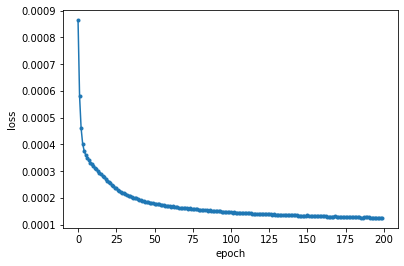

In [ ]:
plot_history(hist)

In [8]:
import matplotlib.pyplot as plt


In [16]:
d='/content/drive/MyDrive/data/final/C01_MAE'
d1='/content/drive/MyDrive/data/final/M01_MAE'

history = pickle.load(open(d, "rb"))
history1 = pickle.load(open(d1, "rb"))


In [26]:
d2='/content/drive/MyDrive/data/final/C01_TSNR'
d3='/content/drive/MyDrive/data/final/M01_TSNR'

history2 = pickle.load(open(d2, "rb"))
history3 = pickle.load(open(d3, "rb"))


In [6]:
d4='/content/drive/MyDrive/data/final/C01_DIC'
d5='/content/drive/MyDrive/data/final/M01_DIC'

history4 = pickle.load(open(d4, "rb"))
history5 = pickle.load(open(d5, "rb"))


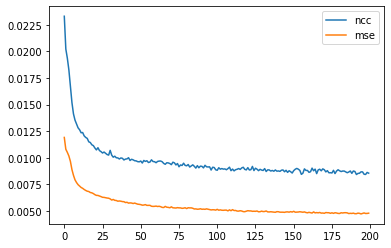

In [20]:
plt.plot(history['val_transformer_MAE'],label='ncc')

plt.plot(history1['val_transformer_MAE'],label='mse')
plt.legend()

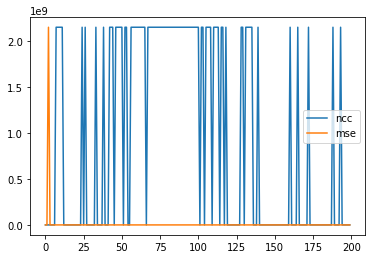

In [27]:
plt.plot(history2['val_transformer_TSNR'],label='ncc')

plt.plot(history3['val_transformer_TSNR'],label='mse')
plt.legend()

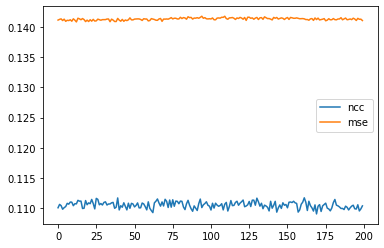

In [17]:
plt.plot(history4['val_transformer_dice_coef'],label='ncc')

plt.plot(history5['val_transformer_dice_coef'],label='mse')
plt.legend()

In [16]:
history4['val_transformer_dice_coef']

[0.11011544615030289,
 0.11067008972167969,
 0.11046791821718216,
 0.10987195372581482,
 0.11013314872980118,
 0.11031591147184372,
 0.11084514111280441,
 0.1107102483510971,
 0.11106111109256744,
 0.11103644222021103,
 0.11045269668102264,
 0.1107877716422081,
 0.11075813323259354,
 0.11134137958288193,
 0.11120651662349701,
 0.11121653765439987,
 0.10999584197998047,
 0.11003081500530243,
 0.11130668222904205,
 0.11061154305934906,
 0.11092354357242584,
 0.11078725755214691,
 0.11148987710475922,
 0.11081115901470184,
 0.1099289059638977,
 0.11166669428348541,
 0.11150234192609787,
 0.11060431599617004,
 0.110811747610569,
 0.11057154089212418,
 0.1109965592622757,
 0.11109762638807297,
 0.11057010293006897,
 0.11073993146419525,
 0.11074242740869522,
 0.11093039810657501,
 0.11100035905838013,
 0.11002515256404877,
 0.110215924680233,
 0.11173664033412933,
 0.10975708067417145,
 0.11045346409082413,
 0.11020075529813766,
 0.11093712598085403,
 0.11035999655723572,
 0.109761841595172

In [14]:
import numpy as np

np.mean(history4['val_transformer_dice_coef'])

0.11055777467787266

In [15]:
np.mean(history5['val_transformer_dice_coef'])

0.1412785918265581

In [ ]:
data_dir_TEST='/home/mahdi/Desktop/data_selection_D7'

In [ ]:
# let's get some data
val_generator = data_generator(data_dir_TEST,32,m,.3)
val_input, _ = next(val_generator)

In [ ]:
val_pred = vxm_model.predict(val_input)

In [ ]:
# visualize
images = [img[18, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
ne.plot.flow([val_pred[1][18].squeeze()], width=10)